# **NBA PREDICTION MODEL**


##### **Input Team Cities As Seen In The Dictionary Below**

In [1]:
HOME = "Detroit"
AWAY = "New York"

##### **Dictionary Mapping Team Cities to Abbreviations**

In [2]:
TEAM_TO_ABBR = {
    "Atlanta": "ATL",
    "Boston": "BOS",
    "Brooklyn": "BRK",
    "Charlotte": "CHO",
    "Chicago": "CHI",
    "Cleveland": "CLE",
    "Dallas": "DAL",
    "Denver": "DEN",
    "Detroit": "DET",
    "Golden State": "GSW",
    "Houston": "HOU",
    "Indiana": "IND",
    "LA Clippers": "LAC",
    "LA Lakers": "LAL",
    "Memphis": "MEM",
    "Miami": "MIA",
    "Milwaukee": "MIL",
    "Minnesota": "MIN",
    "New Orleans": "NOP",
    "New York": "NYK",
    "Oklahoma City": "OKC",
    "Orlando": "ORL",
    "Philadelphia": "PHI",
    "Phoenix": "PHO",
    "Portland": "POR",
    "Sacramento": "SAC",
    "San Antonio": "SAS",
    "Toronto": "TOR",
    "Utah": "UTA",
    "Washington": "WAS"
}

##### **Validates Inputted Teams**

In [3]:
def valid_teams():
    if HOME not in TEAM_TO_ABBR or AWAY not in TEAM_TO_ABBR:
        raise Exception("Please input valid team cities")
    else:
        return True
    
valid_teams()

True

##### **Install**

In [32]:
!pip3 install pandas requests scikit-learn fake_useragent selenium webdriver-manager tensorflow bs4 matplotlib openpyxl

Defaulting to user installation because normal site-packages is not writeable
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


##### **Imports**

In [33]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from bs4 import BeautifulSoup, Comment
import traceback
from pathlib import Path
import random
from fake_useragent import UserAgent
import matplotlib.pyplot as plt
import openpyxl

##### **Basketball Reference Links**


In [5]:
BOX_SCORES = "https://www.basketball-reference.com/boxscores/"
SCORES_BY_DATE = BOX_SCORES + "?month={}&day={}&year={}"
TEAMS = "https://www.basketball-reference.com/teams/"

##### **Get Dates**

In [6]:
def get_last_7_days_from_date(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    last_7_days = [(date - timedelta(days=i+1)).strftime('%Y-%m-%d') for i in range(7)]
    return last_7_days

def get_last_15_days_from_date(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    last_15_days = [(date - timedelta(days=i+1)).strftime('%Y-%m-%d') for i in range(15)]
    return last_15_days

def get_last_30_days_from_date(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    last_30_days = [(date - timedelta(days=i+1)).strftime('%Y-%m-%d') for i in range(30)]
    return last_30_days

def get_2023_2024_season_dates():
    start_date = datetime(2023, 10, 24)
    end_date = datetime(2024, 4, 14)
    date_range = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range((end_date - start_date).days + 1)]
    return date_range

def get_2024_2025_season_dates():
    start_date = datetime(2024, 10, 22)
    end_date = datetime(2025, 4, 13)
    date_range = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range((end_date - start_date).days + 1)]
    return date_range


### **Save Data**

##### **Scores By Dates**

In [8]:
def save_score(date):
    try:
        year, month, day = date.split("-")
        url = SCORES_BY_DATE.format(month, day, year)

        ua = UserAgent()
        headers = {'User-Agent': ua.random}
        data = requests.get(url, headers=headers)

        soup = BeautifulSoup(data.text, "html.parser")

        for ad in soup.find_all("link", href=lambda href: href and "pub.network" in href):
            ad.decompose()
        for ad_script in soup.find_all("script", src=lambda src: src and "pub.network" in src):
            ad_script.decompose()


        content = soup.prettify()
       
        with open("SCORES/{}-{}-{}.html".format(year, month, day), "w+") as f:
            f.write(content)
    
    except Exception as e:
        tb = traceback.extract_tb(e.__traceback__)
        line_number = tb[-1].lineno
        print(f"Exception occurred on line {line_number}: {e}")

def save_2023_2024_season_scores():
    dates = get_2023_2024_season_dates()
    for date in dates:
        save_score(date)
        time.sleep(3.0000001)

def save_2024_2025_season_scores():
    dates = get_2024_2025_season_dates()
    for date in dates:
        save_score(date)
        time.sleep(3.0000001)

save_2023_2024_season_scores()
save_2024_2025_season_scores()

##### **Games By Dates**

In [9]:
def save_games(date):
    try:
        file = "SCORES/{}.html".format(date)
        
        with open(file) as f:   
            page = f.read()
    
        soup = BeautifulSoup(page, "html.parser")
        games = soup.find_all('div', class_="game_summary expanded nohover")
        
        for game in games:            
            home_team = game.find('table', class_="teams").find_all('tr')[1].find_all('td')[0].find('a').get_text().strip()
            away_team = game.find('table', class_="teams").find_all('tr')[0].find_all('td')[0].find('a').get_text().strip()
            
            game_url = game.find('td', class_="right gamelink").find('a')['href'][11:]
            
            url = BOX_SCORES + game_url
            
            data = requests.get(url)

            with open("GAMES/{}-{}-{}.html".format(date, home_team, away_team), "w+") as f:
                f.write(data.text)

            time.sleep(3.0000001)
                
    except Exception as e:
        tb = traceback.extract_tb(e.__traceback__)
        line_number = tb[-1].lineno
        print(f"Exception occurred on line {line_number}: {e}")

def save_2023_2024_season_games():
    dates = get_2023_2024_season_dates()
    for date in dates:
        save_games(date)

def save_2024_2025_season_games():
    dates = get_2024_2025_season_dates()
    for date in dates:
        save_games(date)

save_2023_2024_season_games()
save_2024_2025_season_games()

##### **Current Team Information**

In [10]:
def save_team(team):
    url = TEAMS + TEAM_TO_ABBR[team] + "/2025.html"
    data = requests.get(url)

    with open("TEAMS/{}.html".format(TEAM_TO_ABBR[team]), "w+") as f:
        f.write(data.text)

for team in TEAM_TO_ABBR.keys():
    save_team(team)
    time.sleep(3.0000001)

### **Abstract Methods For Following Dictionaries**

In [27]:
# {
#   date: 
#   {
#       team: [team_stat, opp_stat],
#       team: [team_stat, opp_stat],
#       team: [team_stat, opp_stat],
#       team: [team_stat, opp_stat],
#   },
#   date: 
#   {
#       team: [team_stat, opp_stat],
#       team: [team_stat, opp_stat]
#   },
# }
#

def scrape_team_metrics_from_game(date, home, away, metric_name):
    file = "GAMES/{}-{}-{}.html".format(date, home, away)

    with open(file) as f:
        page = f.read()

    soup = BeautifulSoup(page, 'html.parser')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    for comment in comments:
        comment_soup = BeautifulSoup(comment, 'html.parser')
        div_four_factors = comment_soup.find('div', id='div_four_factors')
        if div_four_factors:
            away_or = float(div_four_factors.find('tbody').find_all('tr')[0].find('td', attrs={'data-stat': metric_name}).get_text())
            home_or = float(div_four_factors.find('tbody').find_all('tr')[1].find('td', attrs={'data-stat': metric_name}).get_text())
            return [home_or, away_or]

def get_all_metrics(metric_name):
    folder_path = Path('GAMES')
    folder_list = list(folder_path.iterdir())
    folder_list.sort()
    folder_list = folder_list[1:]
    all_ratings = {}

    for file_path in folder_list:
        data = file_path.name.split("-")
        date = data[0] + "-" + data[1] +  "-" + data[2]
        home = data[3]
        away = data[4][:len(data[4]) - 5]
        ratings = scrape_team_metrics_from_game(date, home, away, metric_name)
        
        if date not in all_ratings:
            all_ratings[date] = {}
            
        all_ratings[date][home] = ratings
        all_ratings[date][away] = [ratings[1], ratings[0]]

    return all_ratings

def get_metrics(dates, team, metric_dict):
    metrics = []
    for date in dates:
        try:
            metric = metric_dict[date][team]
        except:
            metric = None
        metrics.append(metric)
    return metrics

def get_avg_metrics(dates, team, metric_dict):
    team_metric = 0
    opp_metric = 0
    count = 0
    metrics = get_metrics(dates, team, metric_dict)
    
    for metric in metrics:
        if metric:
            team_metric += metric[0]
            opp_metric += metric[1]
            count += 1

    if count < 10:
        earliest_date = dates[-1]
        date_obj = datetime.strptime(earliest_date, '%Y-%m-%d')
        
        days_back = 30
        while count < 10 and days_back <= 200:
            expanded_dates = [(date_obj - timedelta(days=i)).strftime('%Y-%m-%d') 
                             for i in range(days_back, days_back + 30)]
            
            additional_metrics = get_metrics(expanded_dates, team, metric_dict)
            
            for metric in additional_metrics:
                if metric:
                    team_metric += metric[0]
                    opp_metric += metric[1]
                    count += 1
                    if count >= 10:
                        break
            
            days_back += 30
    
    team_metric /= count
    opp_metric /= count
    return [team_metric, opp_metric]

##### **Offensive Rating**

In [12]:
RTG_DICT = get_all_metrics('off_rtg')

def get_avg_rtgs(dates, team):
    return get_avg_metrics(dates, team, RTG_DICT)

##### **Effective Field Goal Percentage**

In [13]:
FGP_DICT = get_all_metrics('efg_pct')

def get_avg_efgs(dates, team):
    return get_avg_metrics(dates, team, FGP_DICT)

##### **Turnover Percentage**

In [14]:
TOV_DICT = get_all_metrics('tov_pct')

def get_avg_tovs(dates, team):
    return get_avg_metrics(dates, team, TOV_DICT)

##### **Offensive Rebound Percentage**

In [15]:
ORB_DICT = get_all_metrics('orb_pct')

def get_avg_orbs(dates, team):
    return get_avg_metrics(dates, team, ORB_DICT)

##### **Current And Past Injury Information**

In [16]:
def scrape_team_roster(team):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])

    with open(file) as f:
        page = f.read()
        
    soup = BeautifulSoup(page, "html.parser")

    roster = []
    roster_data = soup.find('div', id='div_roster').find_all('tr')
    for player_data in roster_data:
        player = player_data.find('td', attrs={'data-stat': 'player'})
        if player:
            roster.append(player.find_all('a')[0].get_text())
    
    return roster

def scrape_team_injuries(team):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])
    
    with open(file) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, "html.parser")
   
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    
    for comment in comments:
        comment_soup = BeautifulSoup(comment, 'html.parser')  
        div_injuries = comment_soup.find('div', class_='table_container', id='div_injuries')
        if div_injuries:
            injuries = div_injuries.find('tbody').find_all('a')
            count = -1
            reserves = []
            for injury in injuries:
                count += 1
                if injury and count % 2 == 0:
                    reserves.append(injury.get_text())
            return reserves

def scrape_injuries_from_date(date, home, away):
    file = "GAMES/{}-{}-{}.html".format(date, home, away)

    with open(file) as f:
        page = f.read()

    soup = BeautifulSoup(page, "html.parser")
    inactives = soup.find('strong', text='Inactive:\xa0').find_parent('div').find_all('a')
    injuries = []
    for inactive in inactives:
        injuries.append(inactive.get_text())
    
    return injuries

##### **Injury Impact By Player Value**

In [17]:
def get_player_value(ppg, rpg, apg, spg, bpg):
    return ppg + (1.2 * rpg) + (1.5 * apg) + (2 * spg) + (2 * bpg)

def scrape_team_value(team):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])
    
    with open(file) as f:
        page = f.read()

    soup = BeautifulSoup(page, "html.parser")
    players = soup.find('table', id='per_game_stats').find('tbody').find_all('tr')

    total = 0

    for player in players:
        ppg = float(player.find('td', attrs={'data-stat': 'pts_per_g'}).get_text())
        rpg = float(player.find('td', attrs={'data-stat': 'trb_per_g'}).get_text())
        apg = float(player.find('td', attrs={'data-stat': 'ast_per_g'}).get_text())
        spg = float(player.find('td', attrs={'data-stat': 'stl_per_g'}).get_text())
        bpg = float(player.find('td', attrs={'data-stat': 'blk_per_g'}).get_text())
        total += get_player_value(ppg, rpg, apg, spg, bpg)
        
    return total

def scrape_player_value(team, player_name):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])
    
    with open(file) as f:
        page = f.read()

    soup = BeautifulSoup(page, "html.parser")
    players = soup.find('table', id='per_game_stats').find('tbody').find_all('tr')

    for player in players:
        name = player.find('td', attrs={'data-stat': 'name_display'}).find('a').get_text()
        if name == player_name: 
            ppg = float(player.find('td', attrs={'data-stat': 'pts_per_g'}).get_text())
            rpg = float(player.find('td', attrs={'data-stat': 'trb_per_g'}).get_text())
            apg = float(player.find('td', attrs={'data-stat': 'ast_per_g'}).get_text())
            spg = float(player.find('td', attrs={'data-stat': 'stl_per_g'}).get_text())
            bpg = float(player.find('td', attrs={'data-stat': 'blk_per_g'}).get_text())
            value =  get_player_value(ppg, rpg, apg, spg, bpg)
            return value

def get_injury_value(injuries, team):
    injury_value = 0
    total_value = scrape_team_value(team)
    if injuries:
        for injury in injuries:
            player_value = scrape_player_value(team, injury)
            if player_value:
                injury_value += player_value
    
    return (total_value - injury_value)

##### **Injury Impact Using Advanced Analytics**

In [18]:
def scrape_team_advanced(team):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])

    with open(file) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, "html.parser")

    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    
    for comment in comments:
        comment_soup = BeautifulSoup(comment, 'html.parser')  
        advanced = comment_soup.find('table', id='advanced')
        if advanced:
            advanced = advanced.find('tbody').find_all('tr')
            total = 0
            for player in advanced:
                vorp = float(player.find('td', attrs={'data-stat': 'vorp'}).get_text())
                ws = float(player.find('td', attrs={'data-stat': 'ws'}).get_text())
                total += (vorp * ws)

            return total
    
def scrape_player_advanced(team, player_name):
    file = "TEAMS/{}.html".format(TEAM_TO_ABBR[team])

    with open(file) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, "html.parser")

    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    
    for comment in comments:
        comment_soup = BeautifulSoup(comment, 'html.parser')  
        advanced = comment_soup.find('table', id='advanced')
        if advanced:
            advanced = advanced.find('tbody').find_all('tr')
            for player in advanced:
                name = player.find('td', attrs={'data-stat': 'name_display'}).find('a').get_text()
                if name == player_name:
                    vorp = float(player.find('td', attrs={'data-stat': 'vorp'}).get_text())
                    ws = float(player.find('td', attrs={'data-stat': 'ws'}).get_text())
                    return vorp * ws

def get_injury_advanced(injuries, team):
    injury_advanced = 0
    total_advanced = scrape_team_advanced(team)
    if injuries:
        for injury in injuries:
            player_advanced = scrape_player_advanced(team, injury)
            if player_advanced:
                injury_advanced += player_advanced
    
    return (total_advanced - injury_advanced) 


##### **Determines If Home Team Won**

In [19]:
def scrape_home_win(date, home, away):
    file = "GAMES/{}-{}-{}.html".format(date, home, away)
    with open(file) as f:
        page = f.read()

    soup = BeautifulSoup(page, "html.parser")
    scores = soup.find('div', class_='scorebox').find_all('div', class_='scores')

    away_score = float(scores[0].find('div', class_='score').get_text())
    home_score = float(scores[1].find('div', class_='score').get_text())

    if home_score > away_score:
        return 1
    else:
        return 0

##### **Last 5 Games**

In [20]:
def scrape_last_5_record(date, home, away):
    date = datetime.strptime(date, "%Y-%m-%d")
    folder_path = Path('GAMES')
    folder_list = list(item.name for item in folder_path.iterdir())
    folder_list.sort()
    folder_list = folder_list[1:]
    folder_list.reverse()
    filtered_list = [
        item for item in folder_list
        if datetime.strptime(item[:10], "%Y-%m-%d") < date
    ]
    home_count, away_count = 0, 0
    home_win, away_win = 0, 0
    for file in filtered_list:
        data = file.split("-")
        if home in file or away in file:
            game_outcome = scrape_home_win(data[0] + "-" + data[1] + "-" + data[2], data[3], data[4][:len(data[4]) - 5])
            if home in file and home_count < 5:
                home_count += 1
                if home == data[3]:
                    home_win += game_outcome
                else:
                    home_win += (game_outcome == 0)
        
            if away in file and away_count < 5:
                away_count += 1
                if away == data[3]:
                    away_win += game_outcome
                else:
                    away_win += (game_outcome == 0)
        if home_count == 5 and away_count == 5:
            break
        
    try:    
        home_ratio = home_win / home_count
    except:
        home_ratio = 0
    try:
        away_ratio = away_win / away_count
    except:
        away_ratio = 0

    return home_ratio, away_ratio



##### **Back to back games**

In [21]:
def scrape_back_to_back(date, home, away):
    date = datetime.strptime(date, "%Y-%m-%d")
    previous_date = (date - timedelta(days=1)).strftime("%Y-%m-%d")
    folder_path = Path('GAMES')
    folder_list = list(folder_path.iterdir())

    homeb2b = 0
    awayb2b = 0    

    for file_path in folder_list:
        if file_path.is_file() and file_path.name[:10] == previous_date and home in file_path.name:
            homeb2b = 1
        if file_path.is_file() and file_path.name[:10] == previous_date and away in file_path.name:
            awayb2b = 1
        if homeb2b == 1 and awayb2b == 1:
            break
        
    return homeb2b, awayb2b



### **ORGANIZE DATA**

##### **Training Data**

In [22]:
def get_training_data_from_date(date, home, away):
    home_rtg, away_rtg = scrape_team_metrics_from_game(date, home, away, "off_rtg")
    home_efg, away_efg = scrape_team_metrics_from_game(date, home, away, "efg_pct")
    home_tov, away_tov = scrape_team_metrics_from_game(date, home, away, "tov_pct")
    home_orb, away_orb = scrape_team_metrics_from_game(date, home, away, "orb_pct")
    
    injuries = scrape_injuries_from_date(date, home, away)

    home_injury_value = get_injury_value(injuries, home)
    away_injury_value = get_injury_value(injuries, away)

    home_injury_advanced = get_injury_advanced(injuries, home)
    away_injury_advanced = get_injury_advanced(injuries, away)

    home_b2b, away_b2b = scrape_back_to_back(date, home, away)
    #home_last_5, away_last_5 = scrape_last_5_record(date, home, away)


    home_win = scrape_home_win(date, home, away)

    return [
            home, away, 
            home_rtg, away_rtg, 
            home_efg, away_efg,
            home_tov, away_tov,
            home_orb, away_orb,
            home_injury_value, away_injury_value,
            home_injury_advanced, away_injury_advanced,
            home_b2b, away_b2b,
            #home_last_5, away_last_5,
            home_win
            ]

def get_all_training_data():
    try:
        folder_path = Path('GAMES')
        folder_list = list(folder_path.iterdir())
        folder_list.sort()
        game_data = []
        training_dates = get_2023_2024_season_dates()
        for file_path in folder_list:
            if file_path.is_file() and file_path.name != ".DS_Store" and file_path.name[:10] in training_dates:
                data = file_path.name.split("-")
                date = data[0] + "-" + data[1] + "-" + data[2]
                home = data[3]
                away = data[4][:len(data[4]) - 5]
                game = get_training_data_from_date(date, home, away)
                print(game)
                game_data.append(game)
        return game_data
    
    except Exception as e:
        tb = traceback.extract_tb(e.__traceback__)
        line_number = tb[-1].lineno
        print(f"Exception occurred on line {line_number}: {e}")
   
columns = [
    "Home", "Away", 
    "Home ORtg", "Away ORtg", 
    "Home eFG%", "Away eFG%",
    "Home TOV%", "Away TOV%",
    "Home ORB%", "Away ORB%",
    "Home Injury Value", "Away Injury Value",
    "Home Injury Advanced", "Away Injury Advanced",
    "Home Back to Back", "Away Back to Back",
    #"Home Last 5 Record", "Away Last 5 Record",
    "Home Win"
]


TRAINING_DATA = get_all_training_data()


/var/folders/ng/17qb206971x8rknwjqdlgc2h0000gn/T/ipykernel_9052/41801705.py:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  inactives = soup.find('strong', text='Inactive:\xa0').find_parent('div').find_all('a')


['Denver', 'LA Lakers', 123.6, 111.1, 0.604, 0.511, 11.1, 10.8, 22.5, 28.3, 308.97999999999996, 397.65000000000003, 197.58, 85.11000000000001, 0, 0, 1]
['Golden State', 'Phoenix', 102.3, 106.2, 0.406, 0.5, 8.8, 15.6, 29.5, 35.4, 379.11, 312.47, 68.02000000000002, 36.96, 0, 0, 0]
['Brooklyn', 'Cleveland', 115.3, 116.3, 0.554, 0.559, 15.9, 9.2, 31.0, 19.6, 439.3, 307.4399999999999, 19.42, 104.38000000000001, 0, 0, 0]
['Charlotte', 'Atlanta', 112.2, 106.4, 0.564, 0.446, 16.3, 10.0, 28.6, 23.5, 458.2, 457.72, 12.369999999999994, 40.63, 0, 0, 1]
['Chicago', 'Oklahoma City', 104.7, 124.9, 0.479, 0.665, 11.3, 15.1, 25.5, 14.7, 369.99999999999994, 309.40999999999997, 43.23, 228.39000000000004, 0, 0, 0]
['Indiana', 'Washington', 129.3, 108.5, 0.617, 0.505, 9.7, 11.4, 22.7, 21.2, 342.03999999999996, 422.15, 86.60000000000002, 6.33, 0, 0, 1]
['LA Clippers', 'Portland', 123.9, 111.8, 0.611, 0.527, 15.6, 15.2, 35.9, 32.6, 352.39000000000004, 333.11999999999995, 104.84000000000002, 29.38999999999999

##### **Format As Input**

In [23]:
def get_input_format(date, home, away, func):
    home_30_days_avgs = func(get_last_30_days_from_date(date), home)
    away_30_days_avgs = func(get_last_30_days_from_date(date), away)
    home_30_days = (home_30_days_avgs[0] + away_30_days_avgs[1]) / 2
    away_30_days = (away_30_days_avgs[0] + home_30_days_avgs[1]) / 2 
    '''
    home_15_days_avgs = func(get_last_15_days_from_date(date), home)
    away_15_days_avgs = func(get_last_15_days_from_date(date), away)
    home_15_days = (home_15_days_avgs[0] + away_15_days_avgs[1]) / 2
    away_15_days = (away_15_days_avgs[0] + home_15_days_avgs[1]) / 2 
    '''
    home_7_days_avgs = func(get_last_7_days_from_date(date), home)
    away_7_days_avgs = func(get_last_7_days_from_date(date), away)
    home_7_days = (home_7_days_avgs[0] + away_7_days_avgs[1]) / 2
    away_7_days = (away_7_days_avgs[0] + home_7_days_avgs[1]) / 2 

    home_ret = (home_30_days + home_7_days) / 2
    away_ret = (away_30_days + away_7_days) / 2

    return home_ret, away_ret

##### **Test Data**

In [28]:
def get_test_data_from_date(date, home, away):
    home_rtg, away_rtg = get_input_format(date, home, away, get_avg_rtgs)
    home_efg, away_efg = get_input_format(date, home, away, get_avg_efgs)
    home_tov, away_tov = get_input_format(date, home, away, get_avg_tovs)
    home_orb, away_orb = get_input_format(date, home, away, get_avg_orbs)
    

    injuries = scrape_injuries_from_date(date, home, away)

    home_injury_value = get_injury_value(injuries, home)
    away_injury_value = get_injury_value(injuries, away)

    home_injury_advanced = get_injury_advanced(injuries, home)
    away_injury_advanced = get_injury_advanced(injuries, away)

    home_b2b, away_b2b = scrape_back_to_back(date, home, away)
    #home_last_5, away_last_5 = scrape_last_5_record(date, home, away)

    home_win = scrape_home_win(date, home, away)

    return [
            home, away, 
            home_rtg, away_rtg, 
            home_efg, away_efg,
            home_tov, away_tov,
            home_orb, away_orb,
            home_injury_value, away_injury_value,
            home_injury_advanced, away_injury_advanced,
            home_b2b, away_b2b,
            #home_last_5, away_last_5,
            home_win
            ]

def get_all_test_data():
    try:
        folder_path = Path('GAMES')
        folder_list = list(folder_path.iterdir())
        folder_list.sort()
        game_data = []
        test_dates = get_2024_2025_season_dates()
        for file_path in folder_list:
            if file_path.is_file() and file_path.name != ".DS_Store" and file_path.name[:10] in test_dates:
                data = file_path.name.split("-")
                date = data[0] + "-" + data[1] + "-" + data[2]
                home = data[3]
                away = data[4][:len(data[4]) - 5]
                game = get_test_data_from_date(date, home, away)
                print(game)
                game_data.append(game)
        return game_data
    
    except Exception as e:
        tb = traceback.extract_tb(e.__traceback__)
        line_number = tb[-1].lineno
        print(f"Exception occurred on line {line_number}: {e}")
        
columns = [
    "Home", "Away", 
    "Home ORtg", "Away ORtg", 
    "Home eFG%", "Away eFG%",
    "Home TOV%", "Away TOV%",
    "Home ORB%", "Away ORB%",
    "Home Injury Value", "Away Injury Value",
    "Home Injury Advanced", "Away Injury Advanced",
    "Home Back to Back", "Away Back to Back",
    #"Home Last 5 Record", "Away Last 5 Record",
    "Home Win"
]

TEST_DATA = get_all_test_data()



/var/folders/ng/17qb206971x8rknwjqdlgc2h0000gn/T/ipykernel_9052/41801705.py:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  inactives = soup.find('strong', text='Inactive:\xa0').find_parent('div').find_all('a')


['Boston', 'New York', 119.505, 115.92499999999998, 0.57675, 0.5393, 11.809999999999999, 11.465, 25.900000000000002, 25.68, 279.80000000000007, 284.02, 140.26999999999998, 116.83000000000001, 0, 0, 1]
['LA Lakers', 'Minnesota', 113.91500000000002, 113.96499999999999, 0.5606499999999999, 0.56575, 14.094999999999999, 13.395, 22.409999999999997, 21.314999999999998, 387.56, 276.7300000000001, 85.19000000000001, 111.47, 0, 0, 1]
['Atlanta', 'Brooklyn', 112.62, 114.18499999999999, 0.53965, 0.55025, 11.965000000000002, 12.12, 21.895000000000003, 22.479999999999997, 436.92, 424.04, 40.63, 15.830000000000002, 0, 0, 1]
['Detroit', 'Indiana', 109.945, 119.315, 0.51705, 0.5687, 11.794999999999998, 11.91, 22.795, 25.7, 339.25, 321.52, 65.29, 86.56000000000002, 0, 0, 0]
['Houston', 'Charlotte', 118.16, 115.80499999999998, 0.552, 0.5627, 11.065000000000001, 12.985, 25.89, 21.48, 313.26000000000005, 451.88, 93.3, 13.579999999999995, 0, 0, 0]
['LA Clippers', 'Phoenix', 111.58500000000001, 112.765, 0.53

### **RANDOM FOREST MODEL**

In [39]:
df_train = pd.DataFrame(TRAINING_DATA, columns=columns)

file_path = 'DATA/training_data.xlsx'
df_train.to_excel(file_path, index=False)
df_train = df_train.drop(columns=["Home", "Away", "Home Back to Back", "Away Back to Back"])


#df_train = pd.get_dummies(df_train, columns=['Home', 'Away'])
#df_train = df_train.astype(float)


df_test = pd.DataFrame(TEST_DATA, columns=columns)

file_path = 'DATA/test_data.xlsx'
df_test.to_excel(file_path, index=False)
df_test = df_test.drop(columns=["Home", "Away", "Home Back to Back", "Away Back to Back"])


#df_test = pd.get_dummies(df_test, columns=['Home', 'Away'])
#df_test = df_test.astype(float)


In [40]:
# Define features and target
features = [col for col in df_train.columns if col != 'Home Win' and col != 'Home' and col != 'Away']
target = 'Home Win'

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

today = "2024-11-28"
'''
home_rtg, away_rtg = get_input_format(today, HOME, AWAY, get_avg_rtgs)
home_efg, away_efg = get_input_format(today, HOME, AWAY, get_avg_efgs)
home_tov, away_tov = get_input_format(today, HOME, AWAY, get_avg_tovs)
home_orb, away_orb = get_input_format(today, HOME, AWAY, get_avg_orbs)


home_injuries = scrape_team_injuries(HOME)
away_injuries = scrape_team_injuries(AWAY)

home_injury_value = get_injury_value(home_injuries, HOME)
away_injury_value = get_injury_value(away_injuries, AWAY)

home_injury_advanced = get_injury_advanced(home_injuries, HOME)
away_injury_advanced = get_injury_advanced(away_injuries, AWAY)

home_b2b, away_b2b = scrape_back_to_back(today, HOME, AWAY)
#home_last_5, away_last_5 = scrape_last_5_record(today, HOME, AWAY)

input_data = { 
    "Home ORtg": [home_rtg], 
    "Away ORtg": [away_rtg], 
    "Home eFG%": [home_efg], 
    "Away eFG%": [away_efg], 
    "Home TOV%": [home_tov], 
    "Away TOV%": [away_tov], 
    "Home ORB%": [home_orb], 
    "Away ORB%": [away_orb], 
    "Home Injury Value": [home_injury_value], 
    "Away Injury Value": [away_injury_value],
    "Home Injury Advanced": [home_injury_advanced], 
    "Away Injury Advanced": [away_injury_advanced],
    "Home Back to Back": [home_b2b],
    "Away Back to Back": [away_b2b],
    #"Home Last 5 Record": [home_last_5], 
    #"Away Last 5 Record": [away_last_5]
}

for col in X_train.columns:
    if col.startswith("Home_") or col.startswith("Away_"):
        input_data[col] = [0]

home = "Home_{}".format(HOME)
away = "Away_{}".format(AWAY)

input_data[home] = [1]
input_data[away] = [1]

# Convert new game data into a DataFrame
prediction_df = pd.DataFrame(input_data)

# Predict the outcome for the new game
prediction = rf_model.predict(prediction_df)
'''
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy *= 100
accuracy = str(accuracy)
accuracy = accuracy[:5] + "%"

print("Model Accuracy:", accuracy)
'''
# Output the prediction
if prediction[0] == 1:
    print(HOME + " will win")
else:
    print(AWAY + " will win")
'''

Model Accuracy: 65.47%


'\n# Output the prediction\nif prediction[0] == 1:\n    print(HOME + " will win")\nelse:\n    print(AWAY + " will win")\n'

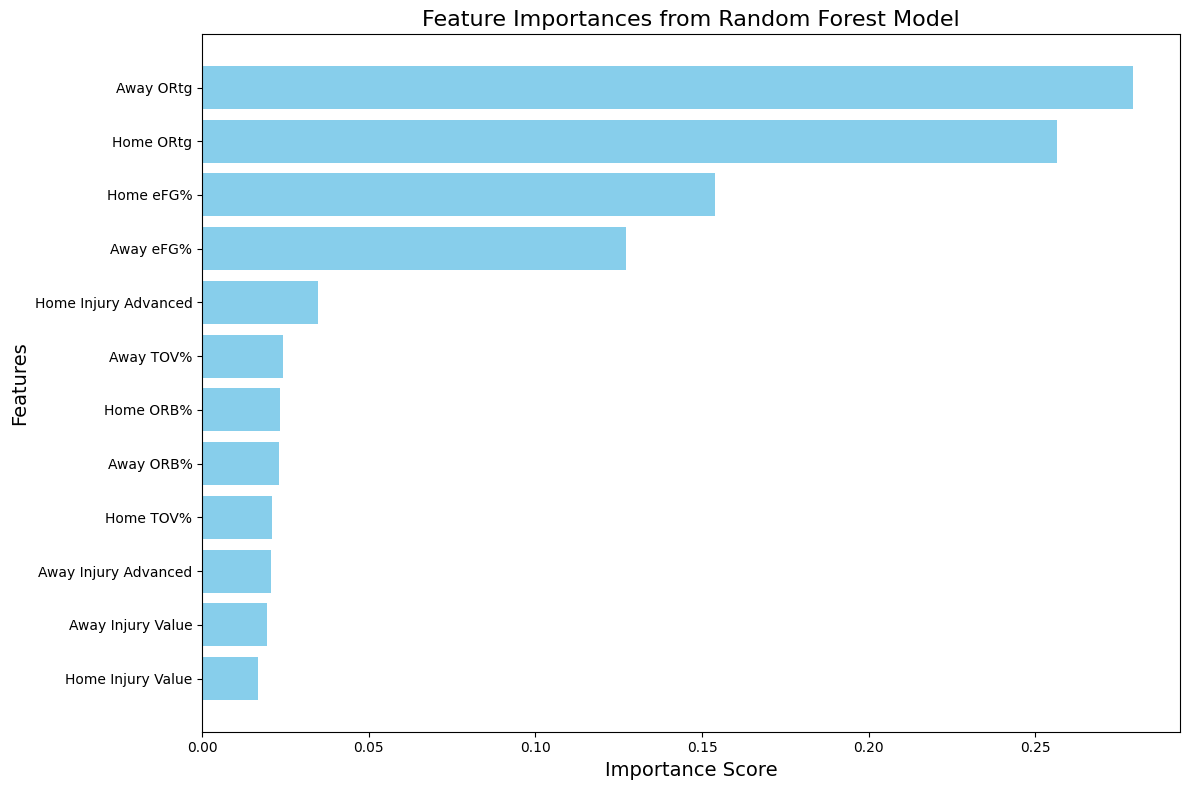

In [41]:


# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a bar graph
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(feature_importances)  # Sort features by importance
plt.barh(np.array(features)[sorted_idx], feature_importances[sorted_idx], color="skyblue")

# Add titles and labels
plt.title("Feature Importances from Random Forest Model", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()

# Display the graph
plt.show()
